**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2023**

---

# Trabajo práctico entregable - Parte 2

Para realizar esta segunda parte, se continua con el mismo dataset con variable de salario mensual neto filtrado de la parte 1 del entregable: solo tiene a la subpoblación full-time y tiene valores entre el SMVM de agosto de 2022 y 600000.

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
from itertools import islice


#Librerías específicas del práctico 2
from scipy import stats
import statsmodels
seaborn.set_context('talk')


In [ ]:
SMVM = float(45540)
max_value = float(600000)

#Actualizamos al CSV del 2022
url ='https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2022_processed.csv' 
df = pd.read_csv(url)

#Columnas elegidas
net_salary  = 'salary_monthly_NETO'
work_dedication = 'work_dedication' #Opciones con .unique(): Full-Time y Part-Time
programming_languages = 'tools_programming_languages'

#Aunque vamos a trabajar con los Full-Time, guardamos también los Part-Time para controlar que filtramos bien
full_time_work = df[df[work_dedication] == 'Full-Time']

#Eliminamos los valores nulos
full_time_work = full_time_work.dropna(subset=[programming_languages]) 

#Convertimos la columna en lista
full_time_work[programming_languages] = full_time_work[programming_languages].str.split(', ')

#Ordenamos de mayor a menor por si es necesario
full_time_work = full_time_work.sort_values(by=net_salary)

full_time_work_without_outliers = full_time_work[(full_time_work['salary_monthly_NETO'] > SMVM) & (full_time_work['salary_monthly_NETO'] < max_value)]

In [ ]:
full_time_work_without_outliers['profile_gender'].unique()

array(['Varón Cis', 'Mujer Cis', 'Varón cis', 'Varón Trans', 'Queer',
       'No binarie', 'Mujer cis', 'Mujer', 'Mujer Trans', 'Gay',
       'Bigénero', 'Fluido', 'mujer', 'Femenino'], dtype=object)

In [ ]:
full_time_work_without_outliers.loc[:,'profile_g'] = full_time_work_without_outliers.profile_gender.replace({'Varón Cis': 'Varón cis','Mujer': 'Mujer cis','Mujer Cis': 'Mujer cis','Femenino': 'Mujer cis','mujer': 'Mujer cis','Mujer':'Mujer cis','Queer':'Diversidades','Varón Trans':'Diversidades','No binarie':'Diversidades','Mujer Trans':'Diversidades','Fluido':'Diversidades','Bigénero':'Diversidades','Gay':'Diversidades'}).fillna(False)

<ipython-input-67-2b1f95669072>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_time_work_without_outliers.loc[:,'profile_g'] = full_time_work_without_outliers.profile_gender.replace({'Varón Cis': 'Varón cis','Mujer': 'Mujer cis','Mujer Cis': 'Mujer cis','Femenino': 'Mujer cis','mujer': 'Mujer cis','Mujer':'Mujer cis','Queer':'Diversidades','Varón Trans':'Diversidades','No binarie':'Diversidades','Mujer Trans':'Diversidades','Fluido':'Diversidades','Bigénero':'Diversidades','Gay':'Diversidades'}).fillna(False)


In [ ]:
full_time_work_without_outliers.profile_g.unique()

array(['Varón cis', 'Mujer cis', 'Diversidades'], dtype=object)

In [ ]:
full_time_work_without_outliers[['profile_g', 'salary_monthly_NETO']].groupby('profile_g').describe()

salary_monthly_NETO                                         \
                           count           mean            std      min   
profile_g                                                                 
Diversidades                69.0  201585.005072   97404.259485  59600.0   
Mujer cis                  717.0  196086.137838   95598.823201  47000.0   
Varón cis                 3341.0  231847.508225  108287.528533  47000.0   

                                                       
                   25%       50%       75%        max  
profile_g                                              
Diversidades  130000.0  189000.0  253892.0  550000.00  
Mujer cis     123500.0  180000.0  242000.0  593415.00  
Varón cis     150000.0  220000.0  289000.0  593092.04

In [ ]:
alpha = 0.05

In [ ]:
is_man = full_time_work_without_outliers.profile_g == 'Varón cis'

groupA = full_time_work_without_outliers[is_man].salary_monthly_NETO
groupB = full_time_work_without_outliers [~is_man].salary_monthly_NETO

## Ejercicio 1: Estimación

**Consigna:**  Calcular una estimación puntual y un intervalo de confianza de nivel (1-alpha) para la resta entre la media del salario Neto para Hombres menos la media del salario Neto para otros géneros(diferencia de las medias entre el grupoA y grupoB). 
¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?

**Respuesta:** la variable groupA contiene los salarios netos de varones cis y la variable groupB hace lo propio con aquellas personas que no son varones cis.
Calculo las medias de los dos grupos y luego su resta.

In [ ]:
mean_difference = groupA.mean()-groupB.mean()

if mean_difference > 0:
  print ('Según la estimación puntual, los varones cis cobran -en promedio- ${0:.2f} más que el grupo conformado por mujeres y diversidades '.format(mean_difference))
elif mean_difference <0:
  print ('Según la estimación puntual, los varones cis cobran -en promedio- ${0:.2f} menos que el grupo conformado por mujeres y diversidades '.format(mean_difference))

else:
  print('Según la estimación puntual, los varones cis y el grupo conformado por mujeres y diversidades cobran -en promedio- lo mismo')

Según la estimación puntual, los varones cis cobran -en promedio- $35278.65 más que el grupo conformado por mujeres y diversidades 


Calcularemos el intervalo de confianza para diferencia de medias 

In [ ]:
#Desviaciones estándar para los dos grupos
standard_deviation_groupA = groupA.std()
standard_deviation_groupB = groupB.std()

standard_error = ((standard_deviation_groupA ** 2) / len(groupA) + (standard_deviation_groupB ** 2) / len(groupB)) ** 0.5 #error estándar

critical_value = stats.norm.ppf(1 - alpha / 2)

margin_of_error = critical_value * standard_error

interval_calculation = (mean_difference-margin_of_error, mean_difference + margin_of_error)

print('El intervalo de confianza es ({0:.2f}, {1:.2f})'.format(interval_calculation[0], interval_calculation[1]))
print("La longitud del intervalor es {0:.2f}".format(interval_calculation[1] - interval_calculation[0]))

El intervalo de confianza es (27646.39, 42910.90)
La longitud del intervalor es 15264.51


**¿Cómo se relaciona este intervalo de confianza con el test de hipótesis?**

**Respuesta** La estimación puntual de la diferencia no es nula y dentro del intervalo de confianza del 95%, tampoco se encuetra el valor 0 (valor en donde la diferencia sería nula). Entonces, a priori, podemos decir que las medias de ambas muestras no van a ser iguales. Sin embargo, nos podemos valer de test de hipotesis para poder rechazar o aceptar esta hipotesis bajo cierto nivel de significancia. 

## Ejercicio 2: Test de hipótesis



### 2.1 Formalización

Describir formalmente los distintos componentes de un test de hipótesis para comprobar si la distribución de los salarios es distinta entre los grupos A y B.

**Hipótesis Nula**

$H_0=...$

**Estadístico (Pivote)**
  * Identificar el estadístico
  * Escribir qué distribución tiene bajo $H_0$


<ipython-input-45-795833cdcbc0>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(groupA)
<ipython-input-45-795833cdcbc0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(groupB)


<Axes: xlabel='salary_monthly_NETO', ylabel='Density'>

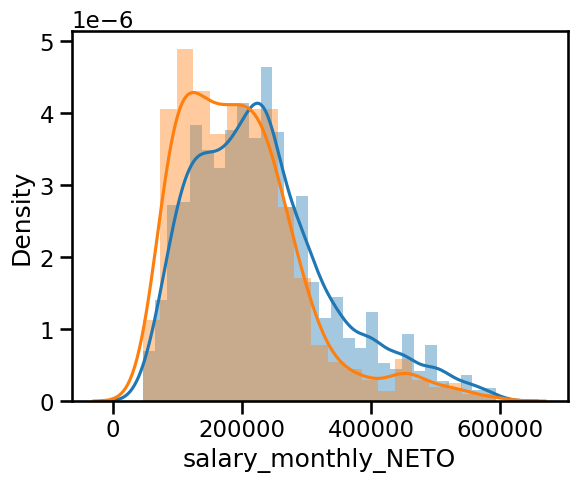

In [ ]:
seaborn.distplot(groupA)
seaborn.distplot(groupB)

Respuesta

La hipotesis nula es
H<sub>0</sub>= Las medias de la distribución de los salarios de varón cis, grupo A, y el resto (mujer cis + diversidades), grupo B son iguales. 

Estadístico pivote: media muestral de los salarios del grupo A y B. Asumimos que la distribución de estas muestras es normal y utilizamos un test de Welsh debido a que no son set de datos apareados (tamaño muestral y varianzas distintas)

alfa o significancia elejida= 0,05



### 2.2 P-valor

1. Calcule el p-valor y decida si rechazar o no la hipótesis nula.
2. Interprete el resultado.

Links útiles:
* [Test de hipótesis usando scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)
* [Test de Welch](http://daniellakens.blogspot.com/2015/01/always-use-welchs-t-test-instead-of.html)

In [ ]:
from scipy import stats

stats.ttest_ind(groupA, groupB, axis=0, equal_var=False, permutations=None, random_state=None, alternative='two-sided', trim=0) #no terminado, revisar

Ttest_indResult(statistic=9.059558824831496, pvalue=4.676217397098482e-19)

Debido a que el p-valor es menor al criterio de significancia la hipotesis nula debe ser rechazada. Es decir podemos aseverar con un 0,05 de significancia que rechazar la H0 es correcto, por lo tanto las medias de Grupo A y B son distintas. 

### [Opcional] 2.3 Potencia del test

Nuestra muestra, ¿era lo suficientemente grande para detectar si existe o no una diferencia entre los grupos?

1. Utilice la función `tt_ind_solve_power` para calcular el tamaño necesario de la muestra para un poder estadístico de 0.8, 0.9 y 0.95, asumiendo una significancia estadística de 0.05.
2. ¿Cómo intepretan el poder estadístico de un test? Dado su conocimiento de dominio sobre los datos, ¿les parece que esta muestra es lo suficientemente grande para ser representativo de la tendencia general? ¿y para utilizarlo en un juicio penal contra una empresa XX por una causa de discriminación?

[Documentación](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.tt_ind_solve_power.html)

NOTA: este análisis debería hacerse ANTES de recolectar los datos.

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
effect_size = (groupA.mean() - groupB.mean()) / groupB.std()
# nobs1=None  - What we want to know
alpha = 0.05
ratio = len(groupB) / len(groupA)
power= 0.8

In [ ]:
tamaño_grupoA_power08=tt_ind_solve_power(effect_size=effect_size, alpha=alpha,power=power,  ratio=ratio)
tamaño_grupoB_power08= ratio*tamaño_grupoA_power08
print(f"Este resultado quiere decir que tendriamos que tener una muesta de {tamaño_grupoA_power08:0.2f} valores para el Grupo A \n y de {tamaño_grupoB_power08:0.2f} valores para el Grupo B con un poder estádistico del 0.8")

Este resultado quiere decir que tendriamos que tener una muesta de 304.88 valores para el Grupo A 
 y de 71.73 valores para el Grupo B con un poder estádistico del 0.8


In [ ]:
tamaño_grupoA_power095=tt_ind_solve_power(effect_size=effect_size, alpha=alpha,power=0.95,  ratio=ratio)
tamaño_grupoB_power095= ratio*tamaño_grupoA_power095
print(f"Este resultado quiere decir que tendriamos que tener una muesta de {tamaño_grupoA_power095:0.2f} valores para el Grupo A \n y de {tamaño_grupoB_power095:0.2f} valores para el Grupo B con un poder estádistico del 0.95")

Este resultado quiere decir que tendriamos que tener una muesta de 503.74 valores para el Grupo A 
 y de 118.51 valores para el Grupo B con un poder estádistico del 0.95


Podríamos decir que las muestras que tenemos son suficientes para no tener un error de tipo II con un poder estadistico de 0,95 (beta). Es decir que para estas medias y desviaciones, los valores n son suficientes para evitar no rechazar si es falsa.

## Ejercicio 3: Comunicación y visualización

**Consigna:** Seleccionen un resultado que les parezca relevante a partir de alguno de los ejercicios del entregable. Diseñe e implemente una comunicación en base a este mensaje, en un archivo PDF.

Elija las palabras y visualización más adecuada para que la comunicación sea entendible, efectiva y se dapte a UNA de las siguientes situaciones:

1. Una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro.
No más de 1 página A4 (o dos si los gráficos son muy grandes).
  1. Ejemplo: Alguna de las secciones [Los ecosistemas de emprendimiento de América Latina y el Caribe frente al COVID-19: Impactos, necesidades y recomendaciones](https://publications.iadb.org/es/los-ecosistemas-de-emprendimiento-de-america-latina-y-el-caribe-frente-al-covid-19-impactos-necesidades-y-recomendaciones), por ejemplo la sección *2.2. Reacciones de los emprendedores*.
  2. Ejemplo: Alguna de las secciones de [The state of gender pay gap in 2021](https://www.payscale.com/data/gender-pay-gap?tk=carousel-ps-rc-job)
  3. Puntos clave: 
    1. Simpleza de los gráficos.
    2. Comunicación en lenguaje simple a personas que no son necesariamente expertos de dominio.
    2. Selección de UNA oración sobre la que se hace énfasis.
    3. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

2. Una publicación científica o reporte técnico interno. No más de una página A4:
  2. Ejemplo: La sección de resultados de [IZA DP No. 12914: The Impact of a Minimum Wage Change on the Distribution of Wages and Household Income](https://www.iza.org/publications/dp/12914/the-impact-of-a-minimum-wage-change-on-the-distribution-of-wages-and-household-income).
  2. Ejemplo: Alguna de las secciones de [Temporary reduction in daily global CO2 emissions during the COVID-19 forced confinement](https://www.nature.com/articles/s41558-020-0797-x)
  3. Puntos clave:
    3. Nivel de detalle técnico requerido. Es necesario justificar la validez del análisis.
    4. La idea presentada puede ser más compleja. Pueden asumir que la audiencia tiene conocimiento técnico y va a analizar las visualizaciones en detalle. 
    5. Pueden presentar más en detalle las limitaciones del análisis (significancia estadística, etc.)
    2. No es necesario que mencionen objetivos ni descripciones del conjunto de datos, se supone que eso ya estaría explicado en otras secciones del informe.

3. Un tweet (o post de LinkedIn) para la cuenta de su empresa consultora que hace análisis de datos. El objetivo es promocionar un análisis de datos abiertos que van a incluir en su portfolio:
  1. Ejemplo: [Comparación vacunas covid](https://twitter.com/infobeautiful/status/1381577746527236098?s=20)
  2. Ejemplo: [Tweet del BID](https://twitter.com/el_BID/status/1388508583944507396?s=20). Lo valioso de este tweet es que usaron un único número para transmitir un mensaje. Puede ser algo así, o con un gráfico muy simple.
  3. Ejemplo: [Cambio climático](https://twitter.com/UNFCCC/status/1387732156190011394?s=20) Es un muy buen ejemplo, excepto que el gráfico no se lee nada y hay que entrar a la publicación original.
  3. Ejemplo: [¿Cuánto están los programadores en las empresas?](https://www.linkedin.com/posts/denis-rothman-0b034043_tech-career-work-activity-6793861923269054464-gS6y) (No verificamos la veracidad o seriedad de la fuente).
  4. Puntos clave:
    1. Su audiencia no va a mirar la visualización por más de unos segundos, y no tiene conocimiento técnico.
  3. Tienen que incluir además una *breve* descripción de cómo obtuvieron los datos que están presentando, que no entraría en el tweet.


Seleccionamos la opción 1: una sección en un artículo de difusión a presentar como parte de una organización sin fines de lucro. Dados los resultados obtenidos en la parte 1 y 2, decidimos seguir trabajando con estos datos porque nos pareció interante mostrar la brecha de genero encontrada.

A continuación, se realizan los gráficos para visualizar los datos:

<ipython-input-72-88ebea5e302f>:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(wedges,labels=profile_g_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))


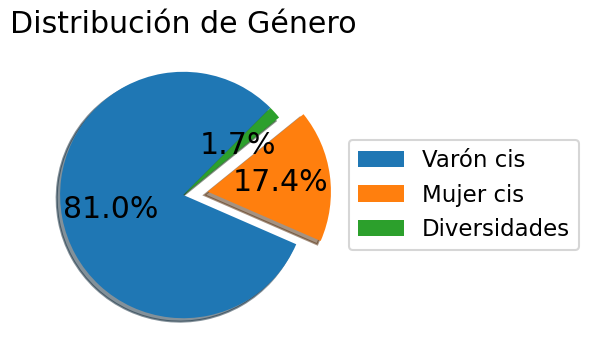

In [ ]:
# Obtener los conteos de cada valor en la columna "profile_g"
profile_g_counts = full_time_work_without_outliers['profile_g'].value_counts()

# Crear la figura y los ejes del gráfico
fig, ax = plt.subplots(figsize=(4, 4))

# Definir el valor que deseas resaltar
valor_resaltado = 'Mujer cis'

# Crear la lista de valores de "explode"
explode = [0.2 if profile == valor_resaltado else 0 for profile in profile_g_counts.index]

# Generar el pie chart
wedges, labels, autopct = ax.pie(profile_g_counts, autopct='%1.1f%%',
       explode=explode,shadow=True, startangle=45, textprops={'size': 'larger'})
for wedge in wedges:
    wedge.set_label('')
ax.set_title('Distribución de Género', size='large')
ax.legend(wedges,labels=profile_g_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))
plt.rcParams['font.size'] = 16
plt.style.use('seaborn-v0_8-pastel')

In [ ]:
df_Varóncis = full_time_work_without_outliers[ full_time_work_without_outliers['profile_g']=='Varón cis']
df_Mujercis = full_time_work_without_outliers[ full_time_work_without_outliers['profile_g']=='Mujer cis']
df_Diversidades = full_time_work_without_outliers[ full_time_work_without_outliers['profile_g']=='Diversidades']

In [ ]:
avg_salary_Varóncis = df_Varóncis ['salary_monthly_NETO'].mean()
print("Promedio salario varón cis:", avg_salary_Varóncis)

avg_salary_Mujercis = df_Mujercis ['salary_monthly_NETO'].mean()
print("Promedio salario mujer cis:", avg_salary_Mujercis)

avg_salary_Diversidades = df_Diversidades ['salary_monthly_NETO'].mean()
print("Promedio salario diversidades:", avg_salary_Diversidades)

pct_salary_m_vs_v= avg_salary_Mujercis *100/ avg_salary_Varóncis
print(pct_salary_m_vs_v, "%")


Promedio salario varón cis: 231847.5082250823
Promedio salario mujer cis: 196086.13783821475
Promedio salario diversidades: 201585.00507246377
84.57547779545266 %


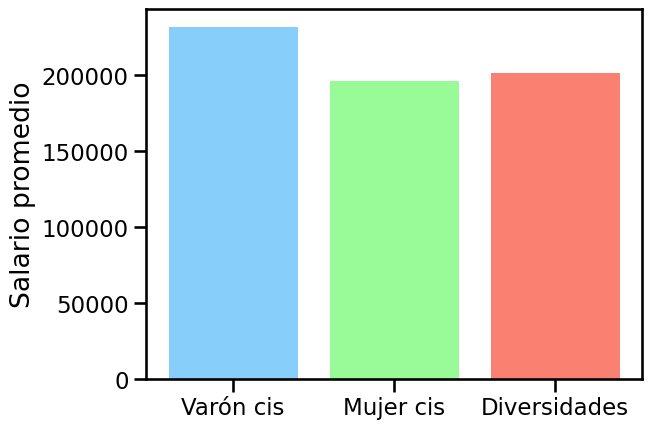

In [ ]:
height = [avg_salary_Varóncis, avg_salary_Mujercis, avg_salary_Diversidades]
plt.bar(x=profile_g_counts.index, height=height, color=('lightskyblue','palegreen','salmon'))
plt.ylabel('Salario promedio',size='large')
plt.show()

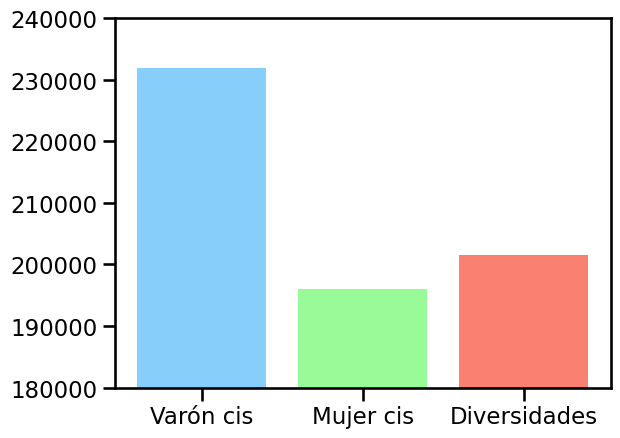

In [ ]:
# Se hace un "zoom" del gráfico anterior para remarcar las diferencias.
x = profile_g_counts.index
height = [avg_salary_Varóncis, avg_salary_Mujercis, avg_salary_Diversidades]
fig, ax = plt.subplots()

ax.bar(x=x, height=height, color=('lightskyblue', 'palegreen', 'salmon'))

ax.set_ylim(180000, 240000)
plt.bar(x=profile_g_counts.index, height=height, color=('lightskyblue','palegreen','salmon'))
plt.show()